#### Aguilar, Jennifer
#### Lanuza, Elton Mark

# CS 282 Mini Project: Utilizing Convolutional Neural Networks in Classifying Sorghum Cultivar Images 

## Preparing Data (This will be executed if you are to start from raw dataset--in kaggle: https://www.kaggle.com/competitions/sorghum-id-fgvc-9/data). Otherwise, Run the codes starting from "Building the architecture itself") if you have the dataset splitted with train/test/val. This is the google link provided from the email)

### Mounting the Google Drive to be used in Google Colab

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np

import os
import shutil

parent_dir = "/content/drive/Cultivar/Dataset/dataset" # Destination
parent_dir_2 = "/content/drive/Cultivar/Dataset/train" # Source

### Defining the Train/Validation/Split Method

In [ ]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=0):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

### Applying the Split Method to the train cultivar mapping csv file

In [ ]:
df = pd.read_csv('train_cultivar_mapping.csv')
train_a, validate_a, test_a = train_validate_test_split(df)
print("train_a: ", train_a['cultivar'])
print("test_a: ", test_a['cultivar'])
print("val_a: ", validate_a['cultivar'])

### Organizing the pictures from original dataset to their respective dataset splits

#### Creating Folders of classes

In [ ]:
parts_data = ['train', 'test', 'val']

for i_parts in parts_data:
    for classes_name in train_a['cultivar'].unique():
        if classes_name != 'Nan':
            class_path = i_parts + '/' + classes_name
            path = os.path.join(parent_dir, class_path)
            os.mkdir(path)
            print("folder name created: ", class_path)

#### Moving the images to Training dataset

In [ ]:
for images_name, class_name in zip(train_a['image'], train_a['cultivar']):
    src_path = parent_dir_2 + '/' + images_name
    dst_path = parent_dir + '/' + parts_data[0] + '/' + class_name + '/' + images_name
    shutil.move(src_path, dst_path)
    print("Train Image: ", images_name, " Moved")

#### Moving the images to Test dataset

In [ ]:
for images_name_2, class_name_2 in zip(test_a['image'], test_a['cultivar']):
    src_path = parent_dir_2 + '/' + images_name_2
    dst_path = parent_dir + '/' + parts_data[1] + '/' + class_name_2 + '/' + images_name_2
    shutil.move(src_path, dst_path)
    print("Test Image: ", images_name_2, " Moved")

#### Moving the images to Validation Dataset

In [ ]:
for images_name_3, class_name_3 in zip(validate_a['image'], validate_a['cultivar']):
    src_path = parent_dir_2 + '/' + images_name_3
    dst_path = parent_dir + '/' + parts_data[2] + '/' + class_name_3 + '/' + images_name_3
    shutil.move(src_path, dst_path)
    print("Validation Image: ", images_name_3, " Moved")

## Building the architecture itself
### Importing required libraries

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import matplotlib.pyplot as plt

plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


### Performing basic image pre-processing. 
#### The input images have size 256x256. The train, validation, and test dataset were randomly cropped to 224x224. The said dimension is the required input for the CNN. The training images were augmented.

In [ ]:
data_dir = '/content/drive/MyDrive/Cultivar/Dataset/dataset'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and randomly flip it horizontally. 
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=2
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes) # There are 100 classes on this dataset

Loaded 13315 images under train
Loaded 4438 images under val
Loaded 4440 images under test
Classes: 
['PI_144134', 'PI_145619', 'PI_145626', 'PI_145633', 'PI_146890', 'PI_152591', 'PI_152651', 'PI_152694', 'PI_152727', 'PI_152728', 'PI_152730', 'PI_152733', 'PI_152751', 'PI_152771', 'PI_152816', 'PI_152828', 'PI_152860', 'PI_152862', 'PI_152923', 'PI_152961', 'PI_152965', 'PI_152966', 'PI_152967', 'PI_152971', 'PI_153877', 'PI_154750', 'PI_154844', 'PI_154846', 'PI_154944', 'PI_154987', 'PI_154988', 'PI_155516', 'PI_155760', 'PI_155885', 'PI_156178', 'PI_156217', 'PI_156268', 'PI_156326', 'PI_156330', 'PI_156393', 'PI_156463', 'PI_156487', 'PI_156871', 'PI_156890', 'PI_157030', 'PI_157035', 'PI_157804', 'PI_167093', 'PI_170787', 'PI_175919', 'PI_176766', 'PI_179749', 'PI_180348', 'PI_181080', 'PI_181083', 'PI_195754', 'PI_196049', 'PI_196583', 'PI_196586', 'PI_196598', 'PI_197542', 'PI_19770', 'PI_213900', 'PI_217691', 'PI_218112', 'PI_221548', 'PI_221651', 'PI_22913', 'PI_229841', 'PI

### Showing the sample batch of training images

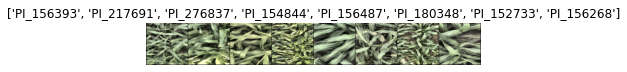

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

### Defining a method that will visualize the images (ground truth vs predicted)

In [ ]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    # Set model for evaluation
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
        
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training) # Revert model back to original training state

### Defining a method that will evaluate the model in test dataset

In [ ]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[TEST]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), requires_grad=False), Variable(labels.cuda(), requires_grad=False)
        else:
            inputs, labels = Variable(inputs, requires_grad=False), Variable(labels, requires_grad=False)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.data
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

### For the CNN, we used VGG-16 pre-trained from pytorch

In [ ]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16_bn()
vgg16.load_state_dict(torch.load("/content/drive/MyDrive/Cultivar/VGG16/vgg16_bn.pth"))
print(vgg16.classifier[6].out_features)

# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Originally, the VGG-16 was tested to predict 1000 classes. In this experiment, we will modify the output layer to use only 100
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16)

1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128

### Helper utilities
#### if we want to continue training after break

In [ ]:
# If you want to train the model for more than 2 epochs, set this to True after the first run
resume_training = False

if resume_training:
    print("Loading pretrained model..")
    vgg16.load_state_dict(torch.load('../input/vgg16-transfer-learning-pytorch/SORGHUM_cultivar.pt'))
    print("Loaded!")

#### Other parameters

In [ ]:
if use_gpu:
    vgg16.cuda() #.cuda() will move everything to the GPU side
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Evaluating the untrained model. As checked, it produced a very low accuracy rate

In [ ]:
print("Test before training")
eval_model(vgg16, criterion)

Test before training
Evaluating model
----------
Test batch 500/555
Evaluation completed in 17m 46s
Avg loss (test): 0.5804
Avg acc (test): 0.0068
----------


### Visualizing the ground truth vs predicted images in untrained model

Ground truth:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


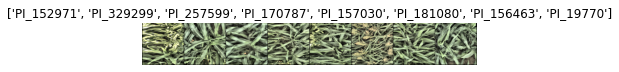

Prediction:


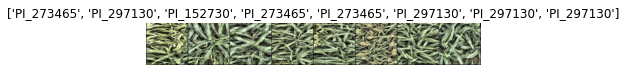

In [ ]:
visualize_model(vgg16) #test before training

## Training the VGG-16 Model

### We will now define the a function in training the VGG-16

In [ ]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[VAL])
    
    avg_acc_train_all = []
    avg_loss_train_all = []
    avg_acc_val_all = []
    avg_loss_val_all = []

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        
        for i, data in enumerate(dataloaders[TRAIN]):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)
                
            # Use half training dataset
            if i >= train_batches / 2:
                break
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.data
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train * 2 / dataset_sizes[TRAIN]
        avg_acc = acc_train * 2 / dataset_sizes[TRAIN]
        
        vgg.train(False)
        vgg.eval()
            
        for i, data in enumerate(dataloaders[VAL]):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), requires_grad=False), Variable(labels.cuda(), requires_grad=False)
            else:
                inputs, labels = Variable(inputs, requires_grad=False), Variable(labels, requires_grad=False)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss_val += loss.data
            acc_val += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / dataset_sizes[VAL]
        avg_acc_val = acc_val / dataset_sizes[VAL]
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        avg_acc_train_all.append(avg_acc)
        avg_loss_train_all.append(avg_loss)
        avg_acc_val_all.append(avg_acc_val)
        avg_loss_val_all.append(avg_loss_val)

        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg, avg_acc_train_all, avg_loss_train_all, avg_acc_val_all, avg_loss_val_all

### We will now train the model given an images. It is iterated with 100 epochs

In [14]:
number_epochs = 100
vgg16, train_acc, train_loss, val_acc, val_loss = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=number_epochs)
torch.save(vgg16.state_dict(), 'SORGHUM_cultivar_dataset.pt') # The model will be saved

Epoch 0/100
----------
Training batch 800/832.5
Validation batch 500/555
Epoch 0 result: 
Avg loss (train): 0.5171
Avg acc (train): 0.0700
Avg loss (val): 0.5350
Avg acc (val): 0.0888
----------

Epoch 1/100
----------
Training batch 800/832.5
Validation batch 500/555
Epoch 1 result: 
Avg loss (train): 0.4143
Avg acc (train): 0.1873
Avg loss (val): 0.4301
Avg acc (val): 0.1814
----------

Epoch 2/100
----------
Training batch 800/832.5
Validation batch 500/555
Epoch 2 result: 
Avg loss (train): 0.3663
Avg acc (train): 0.2615
Avg loss (val): 0.2982
Avg acc (val): 0.3520
----------

Epoch 3/100
----------
Training batch 800/832.5
Validation batch 500/555
Epoch 3 result: 
Avg loss (train): 0.3319
Avg acc (train): 0.3105
Avg loss (val): 0.3470
Avg acc (val): 0.2918
----------

Epoch 4/100
----------
Training batch 800/832.5
Validation batch 500/555
Epoch 4 result: 
Avg loss (train): 0.2989
Avg acc (train): 0.3664
Avg loss (val): 0.3087
Avg acc (val): 0.3515
----------

Epoch 5/100
--------

### Displaying the metrics obtained for plotting

In [25]:
x_epochs = np.arange(1, number_epochs+1)
print("x_epoch: ", x_epochs)
print("train acc: ", train_acc)
print("train loss: ", train_loss)
print("validation acc: ", val_acc)
print("validation loss: ", val_loss)

x_epoch:  [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
train acc:  [tensor(0.0700, device='cuda:0'), tensor(0.1873, device='cuda:0'), tensor(0.2615, device='cuda:0'), tensor(0.3105, device='cuda:0'), tensor(0.3664, device='cuda:0'), tensor(0.4087, device='cuda:0'), tensor(0.4284, device='cuda:0'), tensor(0.4629, device='cuda:0'), tensor(0.4814, device='cuda:0'), tensor(0.5066, device='cuda:0'), tensor(0.5110, device='cuda:0'), tensor(0.5448, device='cuda:0'), tensor(0.5654, device='cuda:0'), tensor(0.5661, device='cuda:0'), tensor(0.5911, device='cuda:0'), tensor(0.5926, device='cuda:0'), tensor(0.6043, device='cuda:0'), tensor(0.

### Visualizing the Training vs Validation Loss throughout epoch

np_train_loss_arr:  [0.51714647 0.41427854 0.3662565  0.3318946  0.29894248 0.27743918
 0.26599166 0.24707516 0.23882213 0.22220746 0.21797946 0.20825614
 0.19492295 0.19609545 0.18247779 0.18085746 0.173627   0.16925561
 0.16168652 0.16260692 0.15241972 0.15083538 0.14417689 0.14632781
 0.14165062 0.13231164 0.13537061 0.1310448  0.13074185 0.12627286
 0.12369029 0.12094854 0.1179198  0.11716132 0.11587504 0.11195795
 0.11334117 0.10636197 0.1037146  0.10668596 0.10445884 0.10196552
 0.09900104 0.09568868 0.09734017 0.09330442 0.09561326 0.09066157
 0.09204279 0.08738361 0.08934449 0.08729226 0.084599   0.08228789
 0.08361552 0.08236181 0.08273939 0.08139179 0.07902593 0.08328521
 0.07981884 0.0748957  0.07492433 0.07573225 0.07543187 0.07384966
 0.07266135 0.07368837 0.07063329 0.07104336 0.07003483 0.06773531
 0.06854667 0.0689979  0.06785467 0.06669565 0.06792656 0.06386398
 0.06515389 0.06645451 0.06123118 0.06276972 0.06478233 0.06228293
 0.06258919 0.06164607 0.0608453  0.058512

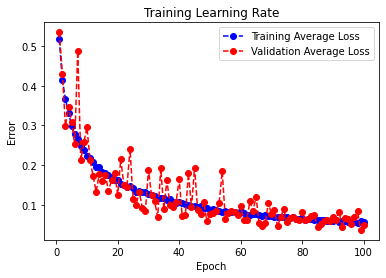

In [28]:
train_loss_arr, val_loss_arr = [], []

# The obtained metrics were originally in tensor, so we will convert it to numpy values.
for i_tensor_train in train_loss:
    tensor_train_loss_np = i_tensor_train.cpu().data.numpy()
    train_loss_arr.append(tensor_train_loss_np)

for i_tensor_val in val_loss:
    tensor_val_loss_np = i_tensor_val.cpu().data.numpy()
    val_loss_arr.append(tensor_val_loss_np)

np_train_loss_arr = np.array(train_loss_arr)
np_val_loss_arr = np.array(val_loss_arr)

print("np_train_loss_arr: ", np_train_loss_arr)
print("np_val_loss_arr: ", np_val_loss_arr)

print(tensor_train_loss_np)
plt.plot(x_epochs, np_train_loss_arr, '--bo', label='Training Average Loss')
plt.plot(x_epochs, np_val_loss_arr, '--ro', label='Validation Average Loss')
plt.title('Training Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

### Visualizing the Training vs Validation Accuracy rates throughout epoch

np_train_acc_arr:  [0.06999625 0.18730754 0.26150957 0.3104769  0.36635372 0.40871197
 0.428389   0.46293652 0.48141193 0.50664663 0.5110026  0.5447991
 0.56537735 0.56612843 0.59106266 0.59256476 0.6042809  0.61614716
 0.6350732  0.6299662  0.6535486  0.6603079  0.6709726  0.65730375
 0.67277503 0.6941044  0.690199   0.6947052  0.7034172  0.7059707
 0.71753657 0.7212917  0.722944   0.7289523  0.7286519  0.741119
 0.7408186  0.75163347 0.75899357 0.7571911  0.7550882  0.7641006
 0.76920766 0.7794217  0.76650393 0.7827262  0.77491546 0.7900863
 0.777469   0.7941419  0.7879834  0.79279006 0.7984979  0.80210286
 0.80120164 0.8055576  0.8060082  0.80811113 0.8100638  0.805107
 0.81742394 0.81742394 0.82523465 0.8190762  0.8229816  0.8243334
 0.82628614 0.8295907  0.8351483  0.8352985  0.8352985  0.8392039
 0.84100634 0.8383026  0.84085613 0.8444611  0.8405557  0.85257226
 0.8471648  0.84085613 0.85227185 0.8488171  0.8464138  0.8486669
 0.85197145 0.856778   0.8545249  0.8644386  0.8587307

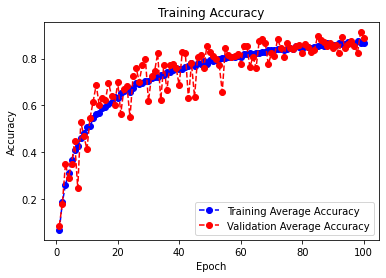

In [29]:
train_acc_arr, val_acc_arr = [], []

# The obtained metrics were originally in tensor, so we will convert it to numpy values.
for i_tensor_train_acc in train_acc:
    tensor_train_acc_np = i_tensor_train_acc.cpu().data.numpy()
    train_acc_arr.append(tensor_train_acc_np)

for i_tensor_val_acc in val_acc:
    tensor_val_acc_np = i_tensor_val_acc.cpu().data.numpy()
    val_acc_arr.append(tensor_val_acc_np)

np_train_acc_arr = np.array(train_acc_arr)
np_val_acc_arr = np.array(val_acc_arr)

print("np_train_acc_arr: ", np_train_acc_arr)
print("np_val_acc_arr: ", np_val_acc_arr)

plt.plot(x_epochs, np_train_acc_arr, '--bo', label='Training Average Accuracy')
plt.plot(x_epochs, np_val_acc_arr, '--ro', label='Validation Average Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluation of Model to Test Dataset

### Evaluation of trained model to test images. As checked, it produced an acceptable accuracy of 0.9169

In [30]:
eval_model(vgg16, criterion)

Evaluating model
----------
Test batch 500/555
Evaluation completed in 0m 34s
Avg loss (test): 0.0365
Avg acc (test): 0.9169
----------


### Finally, visualizing the ground truth vs predicted images in trained model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


Ground truth:


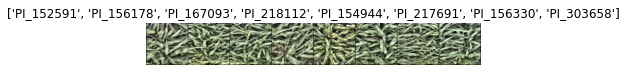

Prediction:


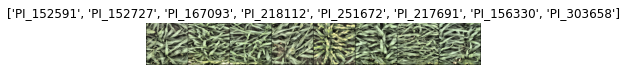

Ground truth:


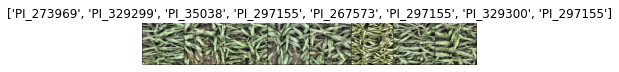

Prediction:


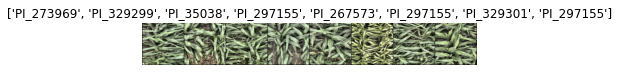

Ground truth:


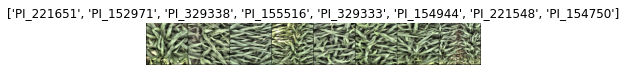

Prediction:


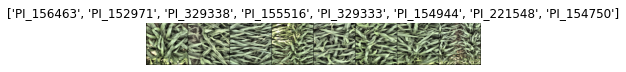

Ground truth:


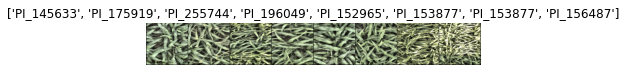

Prediction:


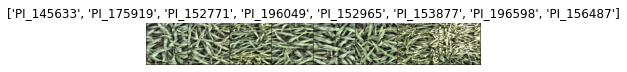

In [31]:
visualize_model(vgg16, num_images=32)